Dependencies

In [ ]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00


In [ ]:
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
accelerate                               1.12.0
access                                   1.1.9
affine                                   2.4.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.12.0
anywidget                           

Limit GPU consumption

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Tesorflow dataset

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
ds = tfds.load('fashion_mnist',split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.HQREJT_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.HQREJT_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()['label']

np.int64(2)

Visualize Data & Build Data

In [ ]:
import numpy as np

In [ ]:
dataiterator = ds.as_numpy_iterator()

Subplot formatting and get 4 images in a batch

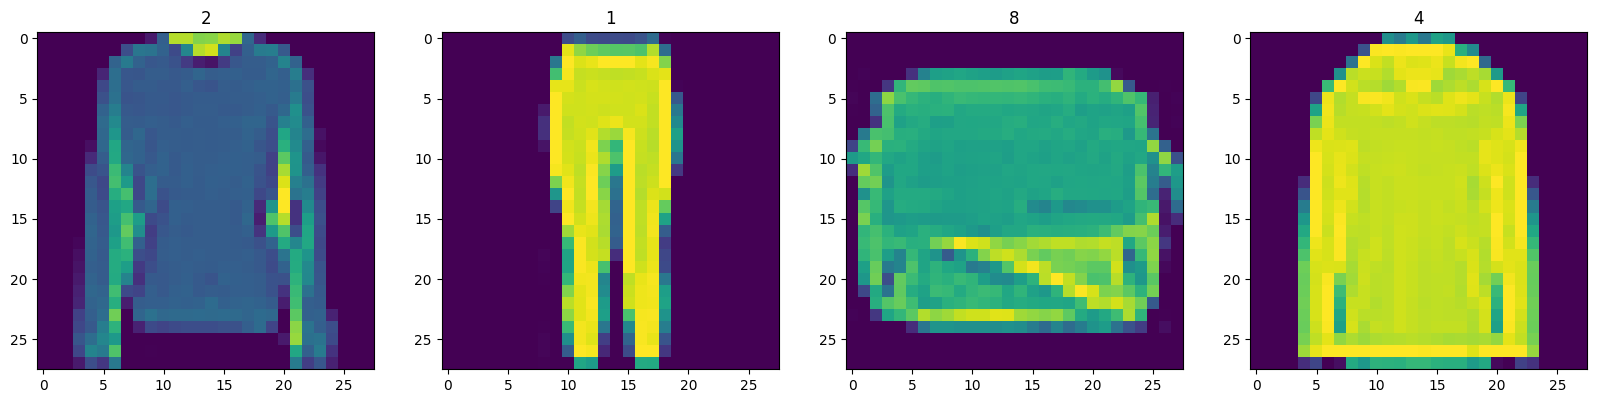

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

Scale and return Images

In [ ]:
def scale_images(data):
  image = data['image']
  return image / 255

In [ ]:
# Reload the dataset
ds = tfds.load('fashion_mnist',split="train")
# scale images
ds = ds.map(scale_images)
# Cache the dataset
ds = ds.cache()
# Shuffle the dataset
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces likelihood of bottlenecking
ds = ds.prefetch(64)

In [ ]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Generator

In [ ]:
def build_generator():
  model = Sequential()

  # takes the random values and reshapes it to 7*7*128
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))


  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

   # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(1,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

   # Convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv Layer to get to one channel
  model.add(Conv2D(1,4,padding="same",activation="sigmoid"))

  return model

In [ ]:
generator = build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 1)      │         3,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 128)    │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,488,514 (5.68 MB)

 Trainable params: 1,488,514 (5.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[[[0.5003221 ],
         [0.4976616 ],
         [0.4977861 ],
         ...,
         [0.50060976],
         [0.4995368 ],
         [0.50037664]],

        [[0.49977025],
         [0.4969668 ],
         [0.4961635 ],
         ...,
         [0.5004306 ],
         [0.4993714 ],
         [0.5007429 ]],

        [[0.498936  ],
         [0.49608278],
         [0.49560663],
         ...,
         [0.49950126],
         [0.49925354],
         [0.5003686 ]],

        ...,

        [[0.4988045 ],
         [0.49814332],
         [0.49909118],
         ...,
         [0.49982977],
         [0.49988416],
         [0.5005526 ]],

        [[0.499343  ],
         [0.49943274],
         [0.4997764 ],
         ...,
         [0.49940774],
         [0.4996941 ],
         [0.5001519 ]],

        [[0.49984255],
         [0.50001687],
         [0.5000115 ],
         ...,
         [0.49918368],
         [0.5001384 ],
         [0.50015455]]],


       [[[0.4994878 ],
         [0.49745855],
         [0.49

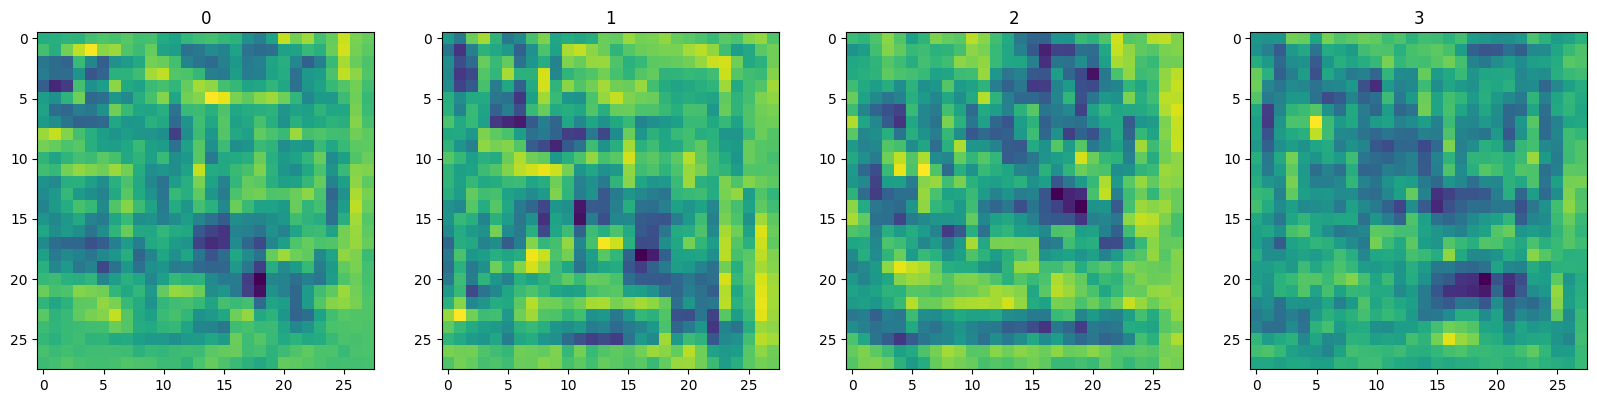

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(img):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

Build Discriminator

In [ ]:
def build_discriminator():
  model = Sequential()

  # Conv Block 1
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 2
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 3
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Conv Block 4
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation="sigmoid"))

  return model

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img.shape

(4, 28, 28, 1)

In [ ]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


array([[0.50643736],
       [0.506484  ],
       [0.506509  ],
       [0.50642973]], dtype=float32)